In [202]:
# Downloads dataset
!wget -nv https://data.mendeley.com/public-files/datasets/bbmmm4wgr8/files/3516f33e-d439-493d-b94c-8121e6f5884c/file_downloaded -O data.csv -nc

In [203]:
import pandas as pd

# Dropping path since we won't use the images
df = pd.read_csv("data.csv").drop("path", axis=1)
df.rename(
    columns={"TaskII": "TaskI", "TaskIII": "TaskII", "TaskIV": "TaskIII"}, inplace=True
)
df.head()

,public_id,lesion_id,patient_id,localization,larger_size,tobacco_use,alcohol_consumption,sun_exposure,gender,skin_color,age_group,diagnosis,dysplasia_severity,TaskI,TaskII,TaskIII
0,0,50,48,Tongue,2.0,Yes,No,No,M,Black,2,OSCC,NaN,OSCC,Presence,OSCC
1,1,50,48,Tongue,2.0,Yes,No,No,M,Black,2,OSCC,NaN,OSCC,Presence,OSCC
2,2,41,39,Tongue,2.5,Yes,Former,Yes,M,White,1,OSCC,NaN,OSCC,Presence,OSCC
3,3,41,39,Tongue,2.5,Yes,Former,Yes,M,White,1,OSCC,NaN,OSCC,Presence,OSCC
4,4,87,81,Lip,1.5,Former,Yes,Yes,F,White,2,OSCC,NaN,OSCC,Presence,OSCC


A primeira etapa consiste no treino e teste com 3 rodadas de validação cruzada estratificada de 10 folds do classificador que não possui hiperparâmetros, isto é, os classificadores ZR e NB.

In [204]:
# Split the data into training and test sets
from sklearn.model_selection import (
    cross_validate,
    RepeatedStratifiedKFold,
    GridSearchCV,
)
from sklearn import preprocessing
from scipy import stats
import numpy as np

# My enroll id ends with `4`, so I'm assigned to TaskII
assigned_task = "TaskII"

X = df.drop(assigned_task, axis=1)
y = df[assigned_task]

# Random state value set assignment specification
rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36851234)

# Converting string labels into numbers
encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(y)
X = X.apply(encoder.fit_transform)


def scores(model) -> dict[str, float]:
    scorings = ["accuracy"]
    scores = cross_validate(model, X, y, scoring=scorings, cv=rkf, n_jobs=-1)
    scores_acc = scores["test_accuracy"]
    scores_mean = scores_acc.mean()
    scores_std = scores_acc.std()
    inf, sup = stats.norm.interval(
        0.95, loc=scores_mean, scale=scores_std / np.sqrt(len(scores_acc))
    )
    return {
        "mean": scores_mean,
        "std": scores_std,
        "inf": inf,
        "sup": sup,
        "raw": scores_acc,
    }


def scores_gridsearch(model, param_grid) -> dict[str, float]:
    clf = GridSearchCV(
        estimator=model, param_grid=param_grid, scoring="accuracy", cv=rkf, n_jobs=-1
    )
    return scores(clf)

In [205]:
from sklearn.dummy import DummyClassifier

zeroR = DummyClassifier(strategy="most_frequent")
zeroR_scores = scores(zeroR)
print(f"ZeroR: {zeroR_scores}")

ZeroR: {'mean': 0.7597826086956523, 'std': 0.014943181613986452, 'inf': 0.754435358089203, 'sup': 0.7651298593021015, 'raw': array([0.75     , 0.75     , 0.75     , 0.75     , 0.75     , 0.75     ,
       0.75     , 0.7826087, 0.7826087, 0.7826087, 0.75     , 0.75     ,
       0.75     , 0.75     , 0.75     , 0.75     , 0.75     , 0.7826087,
       0.7826087, 0.7826087, 0.75     , 0.75     , 0.75     , 0.75     ,
       0.75     , 0.75     , 0.75     , 0.7826087, 0.7826087, 0.7826087])}


In [206]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()
naive_bayes_scores = scores(naive_bayes)
print(f"Naive Bayes: {naive_bayes_scores}")

Naive Bayes: {'mean': 1.0, 'std': 0.0, 'inf': nan, 'sup': nan, 'raw': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}


/home/henriquelay/.cache/pypoetry/virtualenvs/trab1-e0VrW60D-py3.12/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/henriquelay/.cache/pypoetry/virtualenvs/trab1-e0VrW60D-py3.12/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


A segunda etapa consiste no treino, validação e teste dos classificadores que precisam de ajuste de hiperparâmetros, isto é, os classificadores DT, KNN, MLP, RF e HP. Neste caso o procedimento de treinamento, validação e teste será realizado através de 3 rodadas de ciclos aninhados de validação e teste, com o ciclo interno de validação contendo 4 folds e o externo de teste com 10 folds. A busca em grade (grid search) do ciclo interno deve considerar os seguintes valores de hiperparâmetros de cada técnica de aprendizado:
```
Decision Tree: {'criterion': ['gini','entropy'],
                'max_depth': range(1,10)}
K Vizinhos Mais Próximo: {‘n_neighbors’:[1,3,5,7,9]}
Support Vector Machine: {'hidden_layer_sizes': [(100,),(10,)],
                        'activation': ['relu'],
                        'solver': ['adam'],
                        'alpha': [0.0001, 0.05],
                        'learning_rate': ['constant','adaptive']}
Random Forest: {'n_estimators': [50, 100, 150],
                'max_depth': [5, 10, 15, None],
                'max_features': ['sqrt', 'log2', None]}
HeterogeneousPooling: {‘n_samples’: [1, 3, 5, 7]}
```

In [207]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(random_state=11)
decision_tree_scores = scores_gridsearch(
    decision_tree, {"max_depth": list(range(1, 10)), "criterion": ["gini", "entropy"]}
)
print(f"Decision Tree: {decision_tree_scores}")

Decision Tree: {'mean': 1.0, 'std': 0.0, 'inf': nan, 'sup': nan, 'raw': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}


/home/henriquelay/.cache/pypoetry/virtualenvs/trab1-e0VrW60D-py3.12/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/henriquelay/.cache/pypoetry/virtualenvs/trab1-e0VrW60D-py3.12/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [208]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_jobs=-1)
knn_scores = scores_gridsearch(knn, {"n_neighbors": [1, 3, 5, 7, 9]})
print(f"KNN: {knn_scores}")

KNN: {'mean': 0.991304347826087, 'std': 0.026086956521739146, 'inf': 0.981969421858867, 'sup': 1.000639273793307, 'raw': array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.91304348, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.91304348, 0.91304348, 1.        ])}


In [209]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=11)
mlp_scores = scores_gridsearch(
    mlp,
    {
        "hidden_layer_sizes": [(100,), (10,)],
        "activation": ["relu"],
        "solver": ["adam"],
        "alpha": [0.0001, 0.05],
        "learning_rate": ["constant", "adaptive"],
    },
)
print(f"MLP: {mlp_scores}")

/home/henriquelay/.cache/pypoetry/virtualenvs/trab1-e0VrW60D-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/henriquelay/.cache/pypoetry/virtualenvs/trab1-e0VrW60D-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/henriquelay/.cache/pypoetry/virtualenvs/trab1-e0VrW60D-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/henriquelay/.cache/pypoetry/virtualenvs/trab1-e0VrW60D-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron

MLP: {'mean': 0.876388888888889, 'std': 0.0903120239441225, 'inf': 0.8440717400192754, 'sup': 0.9087060377585026, 'raw': array([0.79166667, 0.91666667, 0.79166667, 0.75      , 0.83333333,
       0.79166667, 0.91666667, 1.        , 0.86956522, 0.95652174,
       0.70833333, 0.95833333, 0.70833333, 0.95833333, 0.95833333,
       0.95833333, 0.91666667, 0.7826087 , 0.91304348, 0.95652174,
       0.79166667, 1.        , 0.91666667, 0.83333333, 0.91666667,
       0.91666667, 0.95833333, 1.        , 0.73913043, 0.7826087 ])}


/home/henriquelay/.cache/pypoetry/virtualenvs/trab1-e0VrW60D-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/henriquelay/.cache/pypoetry/virtualenvs/trab1-e0VrW60D-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/henriquelay/.cache/pypoetry/virtualenvs/trab1-e0VrW60D-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/henriquelay/.cache/pypoetry/virtualenvs/trab1-e0VrW60D-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron

In [210]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=11, n_jobs=-1)
rf_scores = scores_gridsearch(
    rf,
    {
        "n_estimators": [50, 100, 150],
        "max_depth": [5, 10, 15, None],
        "max_features": ["sqrt", "log2", None],
    },
)
print(f"RF: {rf_scores}")

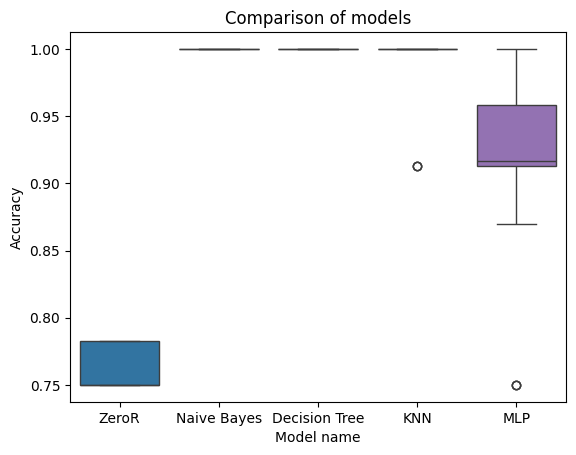

In [ ]:
# Boxplot a comparison between all models
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
ax.set_xlabel("Model name")
sns.boxplot(
    data={
        "ZeroR": zeroR_scores["raw"],
        "Naive Bayes": naive_bayes_scores["raw"],
        "Decision Tree": decision_tree_scores["raw"],
        "KNN": knn_scores["raw"],
        "MLP": mlp_scores["raw"],
        "RF": rf_scores["raw"],
    }
)
plt.ylabel("Accuracy")
plt.title("Comparison of models")
plt.show()